# Wind Power Prediction by LSTM RNN

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

## Data Preperation
### Get data from csv file

In [2]:
def get_data(csv_path):
    data = pd.read_csv(csv_path, header=None)
    npdata = data.values
    return npdata

path_power = "power_output_jz.csv"
data_power = get_data(path_power)
print("Power data shape is", data_power.shape)
# print(data_power)

path_wind = "wind_output_jz.csv"
data_wind = get_data(path_wind)
print("Wind data shape is", data_wind.shape)
# print(data_wind)

path_direc = "direc_output.csv"
data_direc = get_data(path_direc)
print("Wind direction data shape is", data_direc.shape)

path_humi = "humi_output.csv"
data_humi = get_data(path_humi)
print("Humidity data shape is", data_humi.shape)


path_temp = "temp_output.csv"
data_temp = get_data(path_temp)
print("Tempreture data shape is", data_temp.shape)

Power data shape is (366, 48)
Wind data shape is (366, 48)
Wind direction data shape is (366, 48)
Humidity data shape is (366, 48)
Tempreture data shape is (366, 48)


### Data cleaning

In [3]:
def clean_nan(data):
    print("## NaN value found in these location:")
    nan_idx = np.argwhere(np.isnan(data))
    print(nan_idx)
    

    # If there are some NaN values
    if len(nan_idx != 0):
        for idx in nan_idx:
#             print("Before: ", data[idx[0], idx[1]])
            assert(np.isnan(data[idx[0], idx[1]]))
            assert(~np.isnan(data[idx[0], idx[1]-1]))
            assert(~np.isnan(data[idx[0], idx[1]+1]))
            data[idx[0], idx[1]] = np.average([data[idx[0], idx[1]-1], 
                                               data[idx[0], idx[1]+1]]) 
#             print("After: ", data[idx[0], idx[1]])
    return data

data_power_clean = clean_nan(data_power)
data_wind_clean = clean_nan(data_wind)
data_direc_clean = clean_nan(data_direc)

humi_nan_indices = np.argwhere(np.isnan(data_humi))
data_humi[humi_nan_indices] = 0
data_humi_clean = clean_nan(data_humi)

temp_nan_indices = np.argwhere(np.isnan(data_temp))
data_temp[temp_nan_indices] = 0
data_temp_clean = clean_nan(data_temp)
# print("\n## After cleaning, Nan location:")
# print("Power NaN: ", np.argwhere(np.isnan(data_power_clean)))
# print("Wind NaN: ", np.argwhere(np.isnan(data_wind_clean)))
# print("Direction NaN: ", np.argwhere(np.isnan(data_direc_clean)))

## NaN value found in these location:
[]
## NaN value found in these location:
[[223  27]
 [237  31]]
## NaN value found in these location:
[]
## NaN value found in these location:
[]
## NaN value found in these location:
[]


### Data normalization

In [4]:
def flatten(data):
    return data.flatten()

data_power_flatten = flatten(data_power_clean)
data_wind_flatten = flatten(data_wind_clean)
data_direc_flatten = flatten(data_direc_clean)
data_humi_flatten = flatten(data_humi_clean)
data_temp_flatten = flatten(data_temp_clean)

print(data_power_flatten.shape[0])
assert np.shape(data_wind_flatten)[0] == data_power_flatten.shape[0]
assert np.shape(data_direc_flatten)[0] == data_power_flatten.shape[0]

17568


In [5]:
def normalize(data):
    assert(len(np.shape(data)) == 1), \
    "Data pass in normalize() must be flattened!"
    
    max_val = data.max()
    min_val = data.min()
    print('Max value =', max_val, 'Min value =', min_val)
    data_n = (data - min_val) / (max_val - min_val)
    return data_n, max_val, min_val

data_power_normalize, power_max_val, power_min_val = normalize(data_power_flatten) 
data_wind_normalize, wind_max_val, wind_min_val = normalize(data_wind_flatten)
data_direc_normalize, direc_max_val, direc_min_val = normalize(data_direc_flatten)
data_humi_normalize, humi_max_val, humi_min_val = normalize(data_humi_flatten)
data_temp_normalize, temp_max_val, temp_min_val = normalize(data_temp_flatten)

# print("\ndata_power_normalize")
# print("Max:", data_power_normalize.max())
# print("Min:", data_power_normalize.min())
# print("\ndata_wind_normalize")
# print("Max:", data_wind_normalize.max())
# print("Min:", data_wind_normalize.min())
# print("\ndata_direc_normalize")
# print("Max:", data_direc_normalize.max())
# print("Min:", data_direc_normalize.min())

Max value = 1589.0 Min value = -100.0
Max value = 26.47499275 Min value = -0.005214745
Max value = 1.0 Min value = 0.0
Max value = 1.0 Min value = 0.0
Max value = 32.0 Min value = -6.0


### Visualize input data

In [6]:
# # plt.hist(data_power_normalize, bins = 300, normed=True)
# # plt.show()

# _, ax = plt.subplots(figsize=(15,5))
# ax.hist(data_power_normalize, bins=200, normed=True)
# _, bx = plt.subplots(figsize=(15,5))
# bx.hist(data_wind_normalize, bins=200, normed=True)

In [39]:
# _, ax = plt.subplots(figsize=(18,5))
# ax.plot(data_power_normalize[:], label="Power")
# ax.legend()

# _, bx = plt.subplots(figsize=(18,5))
# bx.plot(data_wind_normalize, label="Wind")
# bx.legend()

# _, cx = plt.subplots(figsize=(18,5))
# cx.plot(data_switch_flatten, label="Switch")
# cx.legend()

### Prepare batches

In [42]:
window = 16
batch_size = 125

future_wind = np.roll(data_wind_normalize, -window)
future_direc = np.roll(data_wind_normalize, -window)
future_humi = np.roll(data_humi_normalize, -window)
future_temp = np.roll(data_temp_normalize, -window)

feed_data = np.column_stack((data_power_normalize, \
                             data_wind_normalize, future_wind, \
                             data_direc_normalize, future_direc, \
                             data_humi_normalize, future_humi, \
                             data_temp_normalize, future_temp))
print(feed_data.shape[:])
features = feed_data.shape[1]
print(features)

(17568, 9)
9


In [43]:
def load_data(data, window, features):
    seq_len = window + 1
    breakdown = []
    for index in range(len(data) - seq_len):
        breakdown.append(np.array(data[index: index+seq_len]))
    
    breakdown = np.array(breakdown)
    print("All data", np.shape(breakdown))
    barrier = round(0.9 * breakdown.shape[0])
    train = np.array(breakdown[:int(barrier), :])
    print("Train", np.shape(train))

    x_train = np.array(train[:, :-1])
    print("x_train", np.shape(x_train))
    y_train = np.array(train[:, 1:])
    print("y_train", np.shape(y_train))
    
#     print(np.array(list(
#         zip(x_train[200:210, -1, 0], y_train[200:210, -2, 0])
#     )))
    
    x_test = np.array(breakdown[int(barrier):, :-1])
    print("x_test", np.shape(x_test))
    y_test = np.array(breakdown[int(barrier):, 1:])
    print("y_test", np.shape(y_test))

    return (x_train, y_train, x_test, y_test)
 

# Prepare data
x_train, y_train, x_test, y_test = load_data(feed_data, window, features)

# print("x_train", x_train.shape)
# print("y_train", y_train.shape)
# print("x_test", x_test.shape)
# print("y_test", y_test.shape)


All data (17551, 17, 9)
Train (15796, 17, 9)
x_train (15796, 16, 9)
y_train (15796, 16, 9)
x_test (1755, 16, 9)
y_test (1755, 16, 9)


In [44]:
def combined_shuffle(X, Y):
    combined = np.array(list(zip(X, Y)))
    np.random.shuffle(combined)
    return combined[:,0], combined[:,1]

x_train_shuffled, y_train_shuffled = combined_shuffle(x_train, y_train)
print(x_train_shuffled.shape[:])

(15796, 16, 9)


In [45]:
def split_batches(data):
    length = data.shape[0]
    n_batches = length // batch_size
    remain = length % batch_size
    
    truncated = data[:n_batches*batch_size]
    batches = np.array(np.split(
        truncated.reshape(batch_size, -1, features), n_batches, 1))
    print("From ", truncated.shape, " to ", batches.shape[:], "Discard remain: ", remain)
    return batches

def zip_batches(X, Y):
    return np.array(list(zip(X, Y)))

x_train_batches = split_batches(x_train_shuffled)
y_train_batches = split_batches(y_train_shuffled)

train_batches = zip_batches(x_train_batches, y_train_batches)
print(train_batches.shape[:])



From  (15750, 16, 9)  to  (126, 125, 16, 9) Discard remain:  46
From  (15750, 16, 9)  to  (126, 125, 16, 9) Discard remain:  46
(126, 2, 125, 16, 9)


## Building model

In [46]:
learning_rate = 0.001
lstm_size = 256
rnn_layers = 5

In [74]:
# xxx = [[1,1,1],[2,2,2],[3,3,3],
#        [4,4,4],[5,5,5],[6,6,6],
#        [7,7,7],[8,8,8],[9,9,9]]
# yyy = [9,8,7,6,5,4,3,2,1]

# Build
from tensorflow.contrib import seq2seq

train_graph = tf.Graph()
with train_graph.as_default():
    input_tensor = tf.placeholder(tf.float32, [None, window, features], name='inputs')
    target_tensor = tf.placeholder(tf.float32, [None, window, features], name='targets')

    # LSTM RNN
    lstm = tf.contrib.rnn.BasicLSTMCell(lstm_size)
    rnn_cell = tf.contrib.rnn.MultiRNNCell([lstm] * rnn_layers)
    initial_state = tf.identity(rnn_cell.zero_state(batch_size, tf.float32), name='initial_state')

    rnn_outputs, final_state = tf.nn.dynamic_rnn(rnn_cell, inputs=input_tensor, dtype=tf.float32)
    nn_outputs = tf.contrib.layers.fully_connected(rnn_outputs, features, activation_fn=None)
    prediction = tf.nn.relu(nn_outputs, name='prediction')
    
    total_loss = tf.square(prediction - target_tensor)
    total_cost = tf.reduce_mean(total_loss)
    power_loss = tf.square(prediction[:,-1,0] - target_tensor[:,-1,0])
    power_cost = tf.reduce_mean(power_loss)
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(power_cost)
    # optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)


## Executing the model & RMS/RMSE results

In [82]:
epochs = 30
show_every_n_batches = round(batch_size*2)

In [ ]:
# Train

with tf.Session(graph=train_graph) as sess:
    sess.run(tf.global_variables_initializer())
    
    for epoch_i in range(epochs):
        for bchs_i, (x, y) in enumerate(train_batches):
            feed = {input_tensor: x, target_tensor: y}
            total_c, power_c, _ = sess.run([total_cost, power_cost, optimizer], feed)

            if (epoch_i * batch_size + bchs_i) % show_every_n_batches == 0:
                print('Epoch {:>3} '.format(epoch_i),
                      'Batch {:>4}/{}   '.format(bchs_i,batch_size),
                      'total_cost = {:.3f}   '.format(total_c),
                      'power_cost = {:.3f}'.format(power_c))

    saver = tf.train.Saver()
    save_dir = 'Checkpoints/'
    saver.save(sess, save_dir+"ckpt")
    print('Model Trained and Saved')


Epoch   0  Batch    0/125    total_cost = 0.275    power_cost = 0.174
Epoch   1  Batch  125/125    total_cost = 0.250    power_cost = 0.015
Epoch   2  Batch    0/125    total_cost = 0.258    power_cost = 0.016
Epoch   3  Batch  125/125    total_cost = 0.250    power_cost = 0.011
Epoch   4  Batch    0/125    total_cost = 0.258    power_cost = 0.014
Epoch   5  Batch  125/125    total_cost = 0.249    power_cost = 0.010
Epoch   6  Batch    0/125    total_cost = 0.258    power_cost = 0.014
Epoch   7  Batch  125/125    total_cost = 0.247    power_cost = 0.006
Epoch   8  Batch    0/125    total_cost = 0.256    power_cost = 0.010
Epoch   9  Batch  125/125    total_cost = 0.245    power_cost = 0.005
Epoch  10  Batch    0/125    total_cost = 0.253    power_cost = 0.006
Epoch  11  Batch  125/125    total_cost = 0.246    power_cost = 0.004
Epoch  12  Batch    0/125    total_cost = 0.254    power_cost = 0.005
Epoch  13  Batch  125/125    total_cost = 0.246    power_cost = 0.004
Epoch  14  Batch    

In [84]:
# Test
with tf.Session(graph=train_graph) as sess:
    saver.restore(sess, tf.train.latest_checkpoint(save_dir))
#     for bchs_i, (x, y) in enumerate(test_batches):
#     for bchs_i in range(len(x_test)):
#         x = x_test[bchs_i]
#         y = y_test[bchs_i]
    feed = {
        input_tensor: x_test,
        target_tensor: y_test}
    total_c, power_c = sess.run([total_cost, power_cost], feed)
    print('total_cost = {:.3f}   '.format(total_c),
          'power_cost = {:.3f}'.format(power_c))


total_cost = 0.222    power_cost = 0.006


# Prediction Result

In [85]:
print(x_test.shape[:])
print(y_test.shape[:])
print(y_test[:,-1,0].shape[:])
np.array(list(zip(x_test[:10,-1,0],
                  y_test[:10,-2,0])))

(1755, 16, 9)
(1755, 16, 9)
(1755,)


array([[ 0.31261101,  0.31261101],
       [ 0.48685612,  0.48685612],
       [ 0.64730609,  0.64730609],
       [ 0.86796921,  0.86796921],
       [ 0.62830078,  0.62830078],
       [ 0.52510363,  0.52510363],
       [ 0.8534044 ,  0.8534044 ],
       [ 0.35233867,  0.35233867],
       [ 0.05920663,  0.05920663],
       [ 0.05920663,  0.05920663]])

In [86]:
 with tf.Session(graph=train_graph) as sess:
    saver.restore(sess, tf.train.latest_checkpoint(save_dir))
    feed = {input_tensor: x_test}
    pred = sess.run([prediction], feed_dict=feed)
    pred_val = np.array(pred)[0]
    
    print(pred_val.shape)

(1755, 16, 9)


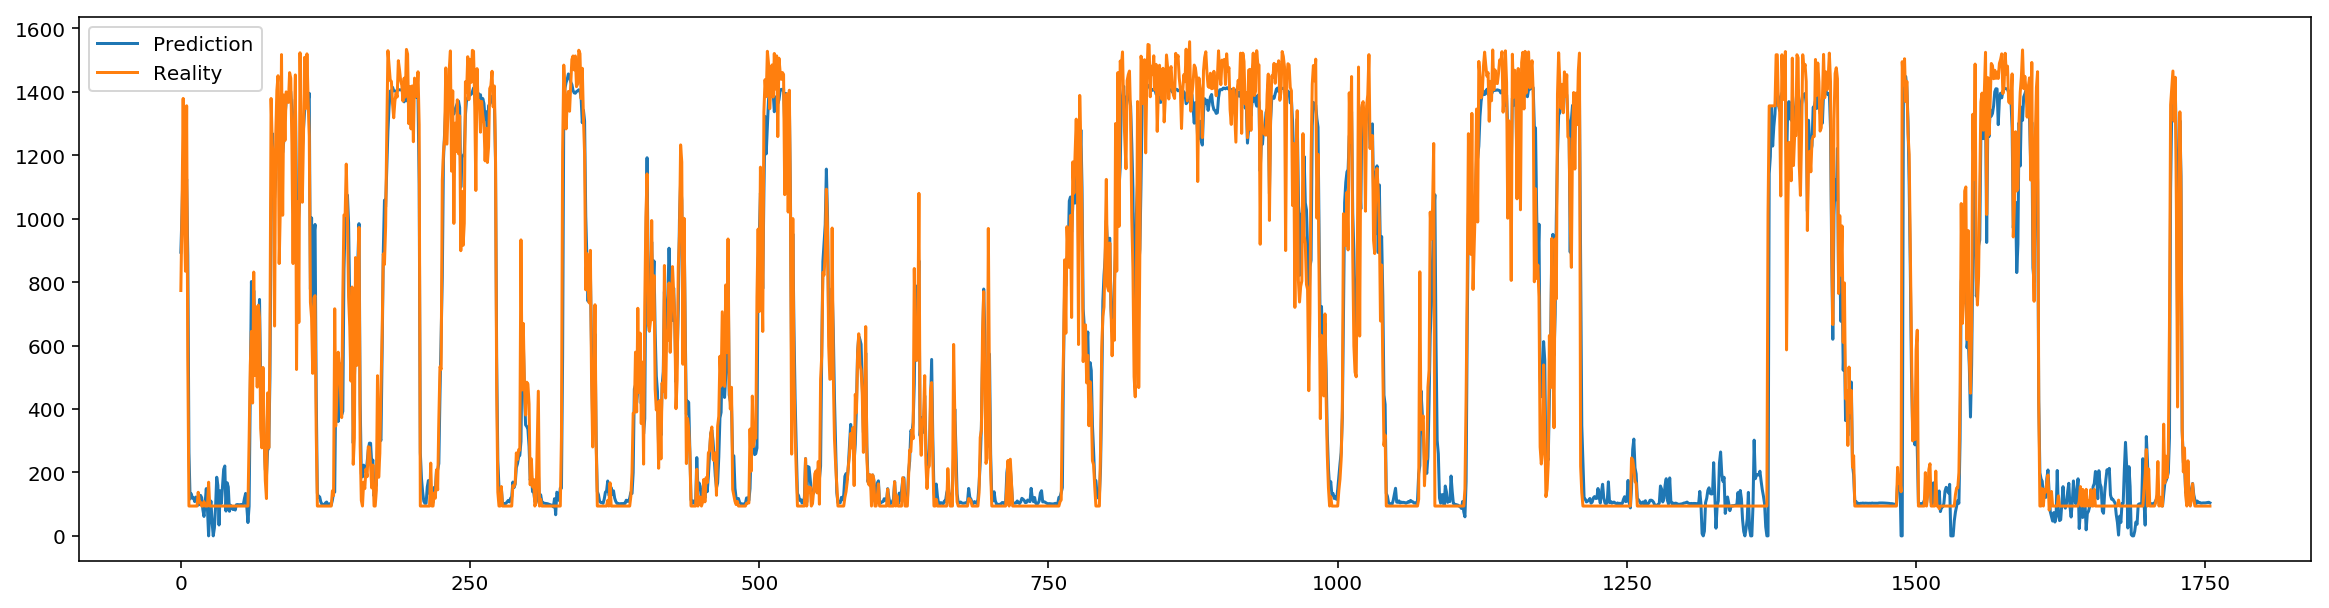

In [87]:
pred_val_power = pred_val[:,-1,0] * power_max_val
test_val_power = y_test[:,-1,0] * power_max_val

_, ax = plt.subplots(figsize=(20,5))
ax.plot(pred_val_power, label="Prediction")
ax.plot(test_val_power, label="Reality")
ax.legend()

## Add cutoff threshold

RMSE:  125.18884991
Cutoff RMSE:  125.18884991
NMAE:  0.0508392092661


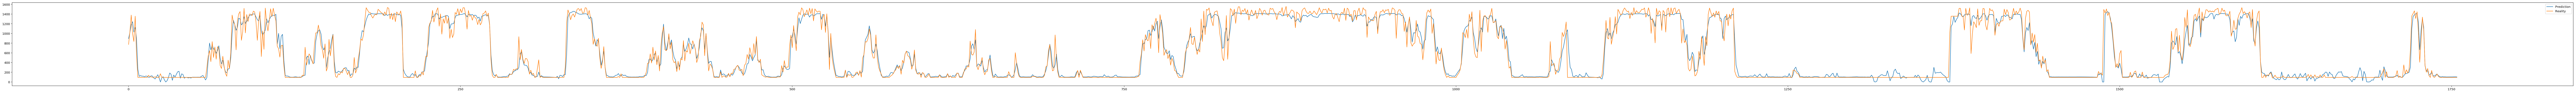

In [88]:
pred_val_power_cutoff = np.array(pred_val_power)
# print(pred_val_power_cutoff)
# low_values_indices = pred_val_power_cutoff < 0  # Where values are low
# print(low_values_indices)
pred_val_power_cutoff[pred_val_power_cutoff < 0] = 0  # All low values set to 0

_, ax = plt.subplots(figsize=(150,5))
ax.plot(pred_val_power_cutoff, label="Prediction")
ax.plot(test_val_power, label="Reality")
ax.legend()


# import math

def rmse(predictions, targets):
    assert(len(predictions) == len(targets))
    return np.sqrt(((predictions - targets) ** 2).mean())

def nmae(predictions, targets):
    return np.sum(np.absolute(predictions - targets)/1500)/len(predictions)

print("RMSE: ", rmse(test_val_power, pred_val_power))
print("Cutoff RMSE: ", rmse(test_val_power, pred_val_power_cutoff))
print("NMAE: ", nmae(test_val_power, pred_val_power))

## Continuous prediction

(1, 16, 9)
(1, 1, 16, 9)
(1, 1, 16, 9)
(1, 1, 16, 9)
(1, 1, 16, 9)
(1, 1, 16, 9)
(1, 1, 16, 9)
(1, 1, 16, 9)
(1, 1, 16, 9)
(1, 1, 16, 9)
(1, 1, 16, 9)
(1, 1, 16, 9)
(1, 1, 16, 9)
(1, 1, 16, 9)
(1, 1, 16, 9)
(1, 1, 16, 9)
(1, 1, 16, 9)
(1, 1, 16, 9)
(1, 1, 16, 9)
(1, 1, 16, 9)
(1, 1, 16, 9)
(1, 1, 16, 9)
(1, 1, 16, 9)
(1, 1, 16, 9)
(1, 1, 16, 9)
(1, 1, 16, 9)
(1, 1, 16, 9)
(1, 1, 16, 9)
(1, 1, 16, 9)
(1, 1, 16, 9)
(1, 1, 16, 9)
(1, 1, 16, 9)
(1, 1, 16, 9)
(1, 1, 16, 9)
(1, 1, 16, 9)
(1, 1, 16, 9)
(1, 1, 16, 9)
(1, 1, 16, 9)
(1, 1, 16, 9)
(1, 1, 16, 9)
(1, 1, 16, 9)
(1, 1, 16, 9)
(1, 1, 16, 9)
(1, 1, 16, 9)
(1, 1, 16, 9)
(1, 1, 16, 9)
(1, 1, 16, 9)
(1, 1, 16, 9)
(1, 1, 16, 9)
(49, 16, 9)


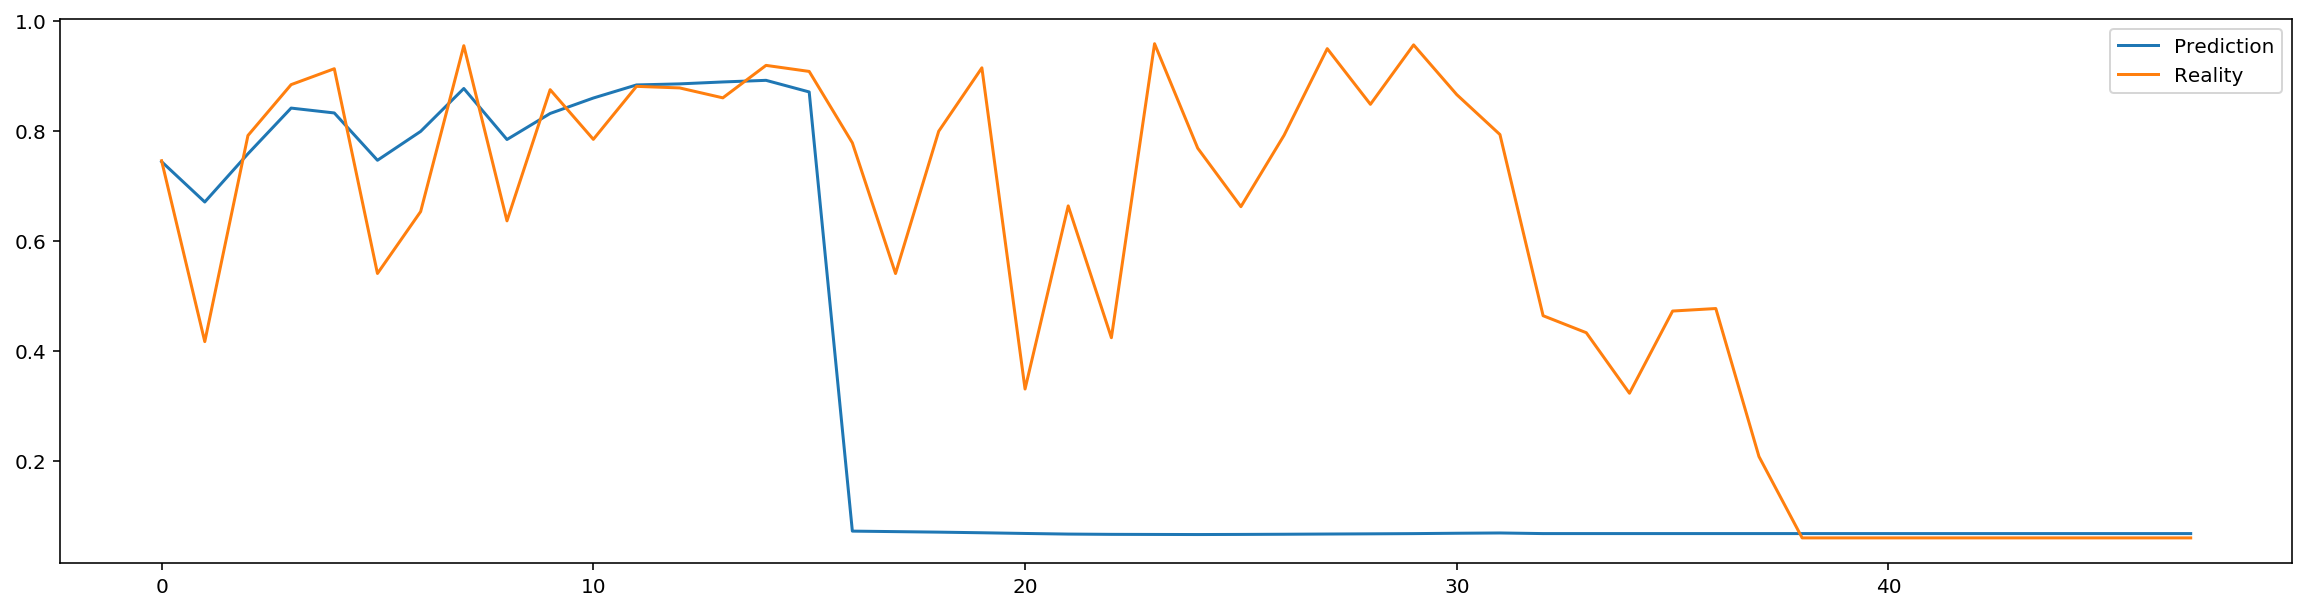

In [89]:
predict_point = 80
predict_length = 48
with tf.Session(graph=train_graph) as sess:
    saver.restore(sess, tf.train.latest_checkpoint(save_dir))
    
    init_x = np.array([x_test[predict_point]])
    print(init_x.shape[:])
    result = list(init_x)
    for i in range(predict_length):
        feed = {input_tensor: init_x}
        pred = sess.run([prediction], feed_dict=feed)
        init_x[0,:-1] = init_x[0,1:]
        print(np.array(pred).shape)
        init_x[0,-1,:] = np.array(pred)[0,0,-1,:]
        result.append(pred[0][0])
    print(np.array(result).shape[:])
    
    power_predict_5h_at_500 = np.array(result)[:,-1,0]
    
_, ax = plt.subplots(figsize=(20,5))
ax.plot(power_predict_5h_at_500[1:], label="Prediction")
ax.plot(y_test[predict_point:predict_point+predict_length,-1,0], label="Reality")
ax.legend()